# Import 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy


---

## Thu thập dữ liệu
Dữ liệu được thu thập trên kaggle.
Link dữ liệu : https://www.kaggle.com/vipin20/loan-application-data  
Đây là tập dữ liệu thông tin về các khoản vay bao gồm thông tin cá nhân của người vay và khoản vay có được chấp nhận hay không.  
File dữ liệu bao gôm :  
- File `df1_loan.csv` : tập dữ liệu 

# Khám phá dữ liệu

## Đọc dữ liệu

![](https://i.pinimg.com/originals/e0/2f/31/e02f319e566acc11cbff272c16a650e1.gif)

In [3]:
data_df = pd.read_csv("Data/df1_loan.csv")
data_df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         500 non-null    int64  
 1   Loan_ID            500 non-null    object 
 2   Gender             491 non-null    object 
 3   Married            497 non-null    object 
 4   Dependents         488 non-null    object 
 5   Education          500 non-null    object 
 6   Self_Employed      473 non-null    object 
 7   ApplicantIncome    500 non-null    int64  
 8   CoapplicantIncome  500 non-null    float64
 9   LoanAmount         482 non-null    float64
 10  Loan_Amount_Term   486 non-null    float64
 11  Credit_History     459 non-null    float64
 12  Property_Area      500 non-null    object 
 13  Loan_Status        500 non-null    object 
 14  Total_Income       500 non-null    object 
dtypes: float64(4), int64(2), object(9)
memory usage: 58.7+ KB


## Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [5]:
data_df.shape

(500, 15)

## Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ, mỗi dòng chứa thông tin của một cá nhân muốn vay và thông tin về việc khoản vay có được chấp nhận hay không

## Dữ liệu có các dòng bị lặp không?

In [6]:
data_df.index.duplicated().sum()

0

## Mỗi cột có ý nghĩa gì?

In [7]:
with open('description.txt', 'r') as f:
    print(f.read())

Loan_ID : Unique Loan application ID
Gender : Gender of applicant male or female
Married : Married Status! Yes or no
Dependents:Dependents of applicant
Education : Education, Graduate or Not Graduate
Self_Employed : Self_Employed! Yes or No
ApplicantIncome : Applicant total Income
CoapplicantIncome : Coapplicant total Income
LoanAmount : Loan Amount apply for loan
Loan_Amount_Term : Loan Amount Term
Credit_History : Credit History
Property_Area : Property Area
Loan_Status : Loan Status, approved or not
Total_Income : Total Icome



## Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [8]:
col_dtypes = data_df.dtypes
col_dtypes

Unnamed: 0             int64
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
Total_Income          object
dtype: object

## Tiền xử lý

### Cột định danh

Có tới 2 cột định danh là cột đầu (chưa được đặt tên) và cột `Loan_ID`.  
Ta sẽ lựa chọn 1 trong 2 cột làm định danh và loại bỏ cột còn lại.  
Ở đây ta sẽ chọn chọn cột đầu (vì nó tốn ít bộ nhớ hơn so với cột `Loan_ID`)

In [9]:
#data_df.drop(columns=['Loan_ID'])
try:
    data_df = data_df.rename({"Unnamed: 0":"Index"},axis=1).set_index("Index").drop(columns=['Loan_ID'])
except:
    pass
data_df = data_df.sort_index(axis=1)
data_df.head(7)

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_Status,Married,Property_Area,Self_Employed,Total_Income
Index,,,,,,,,,,,,,
0,5849,0.0,1.0,0,Graduate,Male,NaN,360.0,Y,No,Urban,No,$5849.0
1,4583,1508.0,1.0,1,Graduate,Male,128.0,360.0,N,Yes,Rural,No,$6091.0
2,3000,0.0,1.0,0,Graduate,Male,66.0,360.0,Y,Yes,Urban,Yes,$3000.0
3,2583,2358.0,1.0,0,Not Graduate,Male,120.0,360.0,Y,Yes,Urban,No,$4941.0
4,6000,0.0,1.0,0,Graduate,Male,141.0,360.0,Y,No,Urban,No,$6000.0
5,5417,4196.0,1.0,2,Graduate,Male,267.0,360.0,Y,Yes,Urban,Yes,$9613.0
6,2333,1516.0,1.0,0,Not Graduate,Male,95.0,360.0,Y,Yes,Urban,No,$3849.0


### Chuyển dtype của cột Toltal_income sang dạng số

Có thể thấy cột `Total_income` thực chât là biểu diễn số liệu nhưng lại được biểu diễn dưới dạng object do có kí tự "\$" đứng trước.  
Ta sẽ tiến hành loại bỏ kí tự "\$" đứng đầu và chuyển về dạng số.  

In [10]:
try:
    data_df.Total_Income = data_df.Total_Income.str[1:].astype(np.float64)
except:
    pass

### Khám phá mới ! `Total_income = ApplicantIncome + CoapplicantIncome`

Theo quan sát, ta thấy được `Total_income = ApplicantIncome + CoapplicantIncome`.  
Kiểm chứng bằng code :

In [11]:
np.all(data_df.ApplicantIncome + data_df.CoapplicantIncome == data_df.Total_Income)

True

Tuy nhiên, em quyết định không loại bỏ hai cột này vì từ hai cột có thể suy ra cột total nhưng từ cột total thì không thể suy ngược lại được. Vì vậy, em quyết định bỏ cột `Total_income` :-)

In [12]:
try:
    data_df = data_df.drop(columns=["Total_Income"])
except:
    pass
data_df.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_Status,Married,Property_Area,Self_Employed
Index,,,,,,,,,,,,
0,5849,0.0,1.0,0,Graduate,Male,NaN,360.0,Y,No,Urban,No
1,4583,1508.0,1.0,1,Graduate,Male,128.0,360.0,N,Yes,Rural,No
2,3000,0.0,1.0,0,Graduate,Male,66.0,360.0,Y,Yes,Urban,Yes
3,2583,2358.0,1.0,0,Not Graduate,Male,120.0,360.0,Y,Yes,Urban,No
4,6000,0.0,1.0,0,Graduate,Male,141.0,360.0,Y,No,Urban,No


# Khám phá dữ liệu (tiếp tục)

## Cột `Dependents`
Là dữ liệu số nhưng phương thức `info()` lại cho ra là object. Ta hãy cùng tìm hiểu vấn đề này

In [13]:
data_df.Dependents.value_counts()

0     288
1      81
2      79
3+     40
Name: Dependents, dtype: int64

Hóa ra do có dự liệu ghi dưới dạng "3+". Ta tiến hành xử lý chuyển 3+ thành 3

In [14]:
try:
    data_df.Dependents = data_df.Dependents.str.replace("+","",regex=False).apply(pd.to_numeric)
except:
    pass

## Phân tích sự phân bố giá trị của các cột

### Xác định các loại cột

Ta sẽ cho cột numeric là các cột có nhiều hơn 10 giá trị khác nhau. Các cột còn lại là category.

In [15]:
cate_cols = data_df.columns[data_df.nunique() <= 9]
nume_cols = data_df.columns[data_df.nunique() > 10]

<AxesSubplot:>

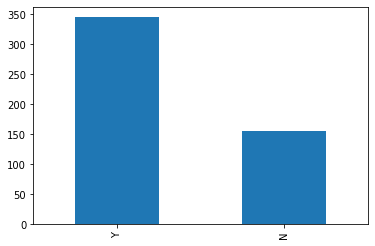

In [24]:
data_df['Loan_Status'].value_counts().plot.bar()

### Dữ liệu categories

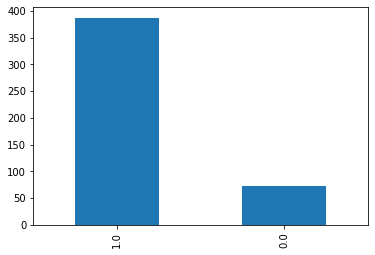

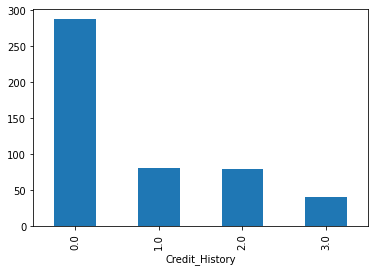

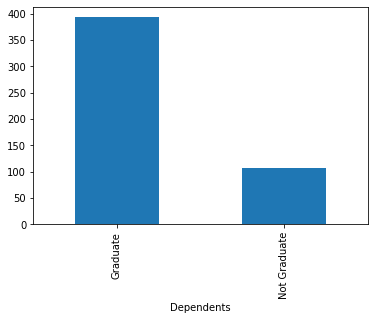

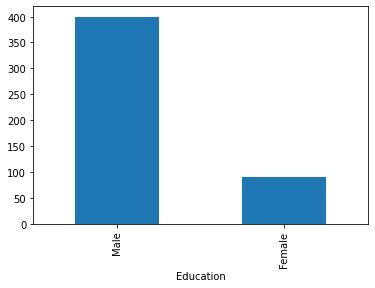

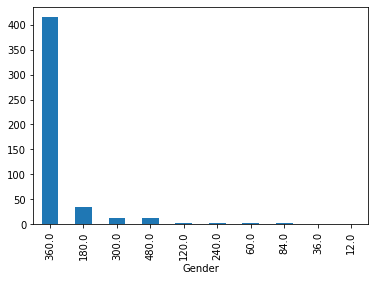

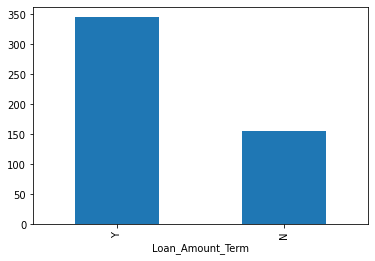

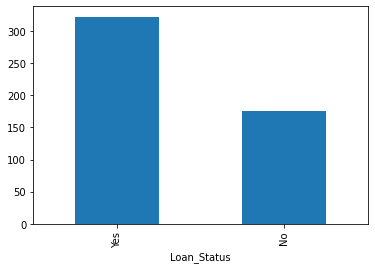

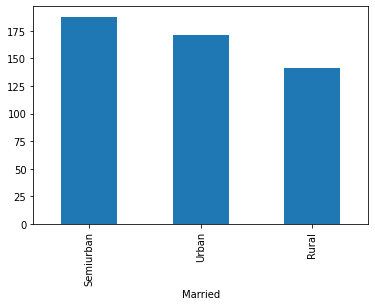

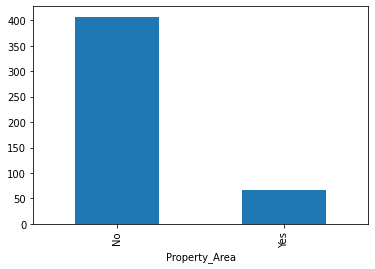

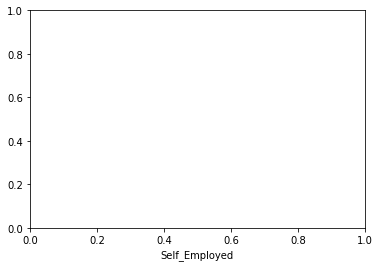

In [26]:
for col in cate_cols:
    data_df[col].value_counts().plot.bar()
    plt.show()
    plt.xlabel(col)


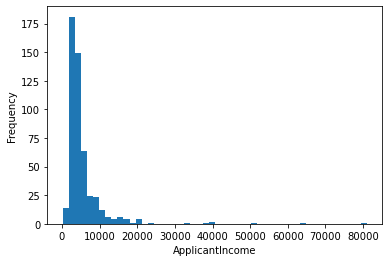

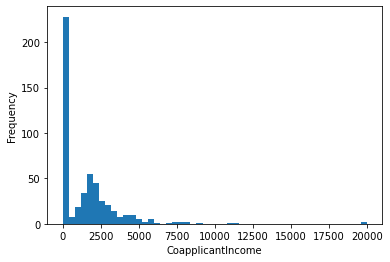

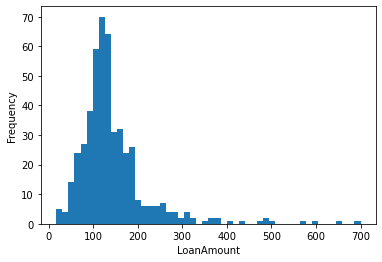

In [17]:
for col in nume_cols:
    data_df[col].plot.hist(bins=50)
    plt.xlabel(col)
    plt.show()

- Ta nhận thấy outlier của các **cột dữ liệu numerical** khá là kinh dị và sẽ rất tệ nếu ta không xử lý chúng.
- Cột `Loan_amount_term` cũng cần phải xử lý 

# Tiếp tục tiền xử lý

## Xóa outlier như thế nào?

- Quan sát biểu đồ được trực quan hóa, ta có thể thấy giá trị của cột cột có dạng phân phối chuẩn (theo kinh nghiệm nhìn biểu đồ nhiều).
- Theo định luật Empirical : https://www.investopedia.com/terms/e/empirical-rule.asp
- 99.7% dữ liệu nằm trong khoảng [mean - 3*std , mean + 3 *std], những phần còn lại nằm ngoài khoảng này đều là linh tinh hết (outlier).

In [18]:
def notOutlierRange(s):
    _mean = s.mean()
    _std = s.std()
    return (_mean - 3 * _std , _mean + 3* _std)

In [19]:
notOutlierRange(data_df.Loan_Amount_Term)

(151.03827826480864, 534.0481414882777)

## Đợi đã, việc xóa này có ảnh hưởng đến tính trực quan của dữ liệu không?

Đầu tiên, ta sẽ xem số outlier bị loại bỏ có nhiều không bằng cách tính tỉ lệ outlier có trong từng cột

In [20]:

for col in nume_cols:
    front,rear = notOutlierRange(data_df[col])
    s = data_df[col]
    before = len(s)
    #print(
    after = len(s.loc[(s > front) & (s < rear)])
    print(col)
    print("{}%".format(((before-after)/after)*100))


ApplicantIncome
1.4198782961460445%
CoapplicantIncome
1.4198782961460445%
LoanAmount
5.932203389830509%


Hai cột trên chỉ có 1.4 %, không đáng quan ngại. Nhưng LoanAmount lên tới 6%!  
Hãy cùng xem tìm chuyện gì sẽ xảy ra nếu ta loại bỏ outlier.

-14053.362915281636 25040.650915281636


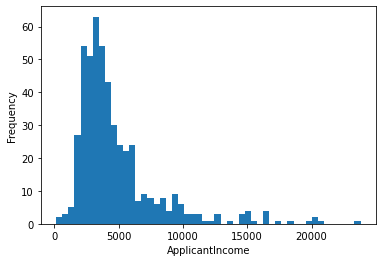

-4896.988722983082 7909.604402937643


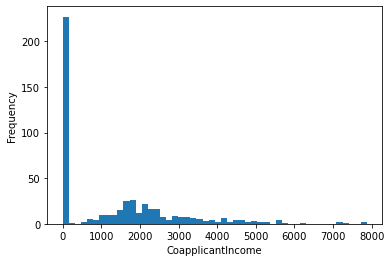

-103.01400927848957 391.0555030544232


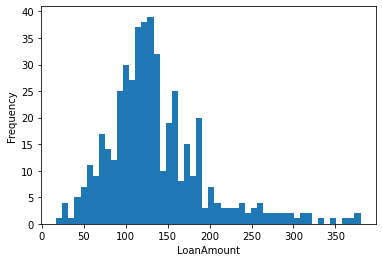

In [21]:
data_df_copy = copy.copy(data_df)
for col in nume_cols:
    front,rear = notOutlierRange(data_df[col])
    print(front,rear)
    s = data_df[col]
    s.loc[(s > front) & (s < rear)].plot.hist(bins=50)
    plt.xlabel(col)
    plt.show()

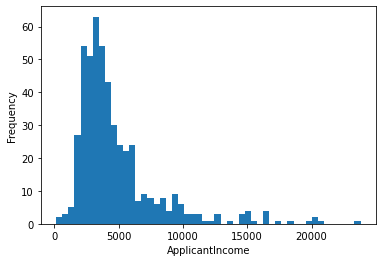

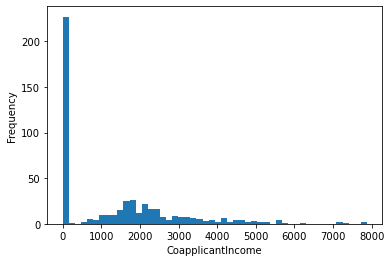

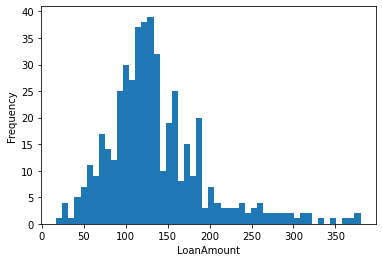

In [22]:
for col in nume_cols:
    front,rear = notOutlierRange(data_df[col])
    s = data_df[col]
    s.loc[(s > front) & (s < rear)].plot.hist(bins=50)
    plt.xlabel(col)
    plt.show()